In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Voting Classifiers
異なる分類器の結果から総合的に判断する。


In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test= train_test_split(X,y, random_state=42)

Hard Voting:多数決  
Soft Voting:クラスの確率をすべての分類器にわたって平均

[VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)の引数votingを`hard`とするか`soft`とするかで切替可能。

これが機能するには各分類器が完全に独立である必要がある。

ランダムフォレスト、ロジスティック回帰、サポートベクターマシンの3つの分類器でテスト。

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf=LogisticRegression(solver="lbfgs", random_state =42)
rnd_clf=RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf=SVC(gamma="scale", random_state=42)

voting_clf=VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [4]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [5]:
log_clf=LogisticRegression(solver="lbfgs", random_state =42)
rnd_clf=RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf=SVC(gamma="scale", probability=True, random_state=42)

voting_clf=VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [6]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


ハードでは0.912、ソフトでは0.92でソフトボーティングのほうがわずかにいい。

# Bagging and Pasting

同じ訓練アルゴリズムに対して異なるサブセットのデータを適用して訓練し複数の予測器を生成する。

元のトレーニングデータに対し
重複ありでサンプリングした場合bagging、重複なしでサンプリングした場合pastingと呼ばれる。

一般的に分類では多数決(statistical mode)、回帰では平均で結果を決める。

オリジナルの訓練セットで訓練した場合と比べ、同等のバイアス、低い分散を得られる。

異なるサーバー上で予測器を並列に訓練、予測できるため人気。

## Bagging and pasting in Scikit-Learn

[BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier)

以下はbaggingの例。
`bootstrap=True`とするとbagging。`bootstrap=False`とするとpasting。

BaggingClassifierは分類器が確率を出力できるなら自動的にsoft votingする。

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf=BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred=bag_clf.predict(X_test)

In [8]:
print(accuracy_score(y_test, y_pred))

0.904


In [9]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree= tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5,2.45, -1, 1.5], alpha =0.5, contour=True):
    x1s=np.linspace(axes[0], axes[1], 100)
    x2s=np.linspace(axes[2], axes[3], 100)
    x1,x2=np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred= clf.predict(X_new).reshape(x1.shape)
    custom_cmap=ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
        plt.plot(X[:,0][y==0], X[:,1][y==0],'yo', alpha=alpha)
        plt.plot(X[:,0][y==1], X[:,1][y==1],'bs', alpha=alpha)
        plt.axis(axes)
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Text(0, 0.5, '')

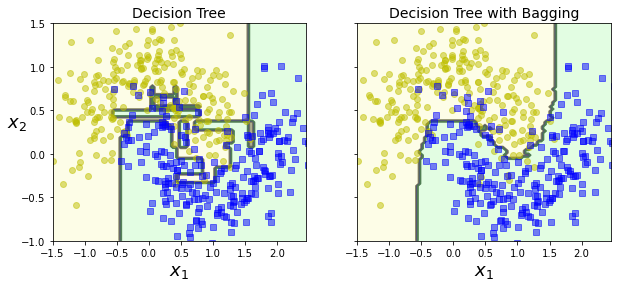

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Tree with Bagging", fontsize=14)
plt.ylabel('')

## Out-of-Bag evaluation

baggingではいくつかのインスタンスは何度もサンプリングされたり、一度もサンプリングされなかったりする。

BaggingClassifierのデフォルトではトレーニングデータ数と同じだけ重複ありでサンプリングするが、これは(データ数が大きいと)63%のデータしか使われないことを意味する。残りのサンプリングされない37%がout of bag(oob)。

oobを検証データのように使うことができる。

sklearnでは`oob_score=True`とするとoobによる検証ができる。結果は`oob_score_`

In [12]:
bag_clf=BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score =True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

decision functionはクラスの確率を返す。

In [13]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [14]:
from sklearn.metrics import accuracy_score
y_pred=bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

# Random Forests

ランダムフォレストは決定木のアンサンブル学習でバギングで訓練(ときどきペースティングの場合もある)している。

In [15]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf= RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf=rnd_clf.predict(X_test)

以下のコード(決定木のバギング)と等価。

In [16]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [17]:
bag_clf.fit(X_train, y_train)
y_pred=bag_clf.predict(X_test)

In [18]:
np.sum(y_pred==y_pred_rf)/len(y_pred)

1.0

## Feature Importance

ランダムフォレストでは特徴の重要度を簡単に測定できる。  
ジニ不純度をもとに計算。

`feature_importances_`で確認できる。

In [19]:
from sklearn.datasets import load_iris
iris=load_iris()
rnd_clf=RandomForestClassifier(n_estimators=500,  random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [20]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

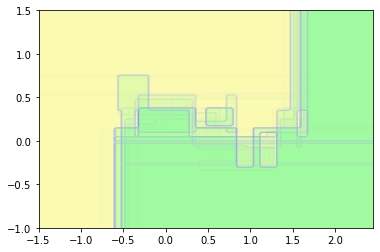

In [21]:
plt.figure(figsize=(6,4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16,random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)


MNISTデータセットで各ピクセルの重要度を可視化する。

In [22]:
from sklearn.datasets import fetch_openml

mnist=fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target=mnist.target.astype(np.uint8)

In [23]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [24]:
def plot_digit(data):
    image=data.reshape(28,28)
    plt.imshow(image, cmap = mpl.cm.hot, 
              interpolation='nearest')
    plt.axis('off')

[Text(1, 0.0, 'Not important'),
 Text(1, 0.009791489757332336, 'Very important')]

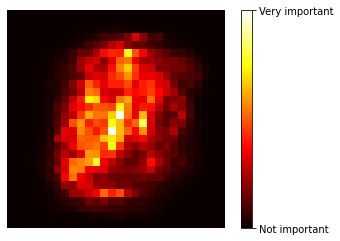

In [25]:
plot_digit(rnd_clf.feature_importances_)
cbar=plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])


# Boosting
Boostingの一般的なアイデアは、予測器の連続的(縦に並べる)な訓練で一つ前の結果を修正しようとする。

## AdaBoost

[AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)はマルチクラス版のAdaBoostであるSAMMEを使う。予測器がクラスの確率を求められれば、より性能が良いSAMME.Rを使える。

1個目の予測器は全訓練データを使い、そこで分類できなかったデータのウェイトを増やしたデータセットを生成、次の予測器にわたす。これを繰り返す。

In [26]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf=AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

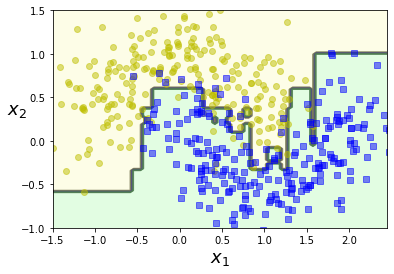

In [27]:
plot_decision_boundary(ada_clf, X,y)

5つの連続した予測器の決定境界。

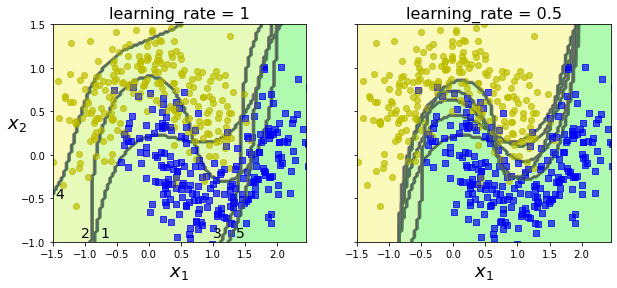

In [28]:
m=len(X_train)

fix, axes = plt.subplots(ncols=2, figsize =(10,4), sharey=True)
for subplot, learning_rate in ((0,1), (1,0.5)):
    sample_weights=np.ones(m)/m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, '1', fontsize=14)
        plt.text(-1.05, -0.95, '2', fontsize=14)
        plt.text(1.0, -0.95, '3', fontsize=14)
        plt.text(-1.45, -0.5, '4', fontsize=14)
        plt.text(1.36, -0.95, '5', fontsize=14)
    else:
        plt.ylabel('')

Boostingは並列化できないという欠点がある。

## Gradient Boosting

勾配ブースティングでは、次の予測器が前の予測器の残差にフィッティングしようとする。

In [29]:
np.random.seed(42)
X=np.random.rand(100,1) -0.5
y=3*X[:,0]**2 + 0.05 *np.random.randn(100)

ベース予測器に決定木を用いた回帰の例。これをGradient Boosted Regression Trees(GBRT)と呼ぶ。

初段ではいつもどおりフィッティング。

In [30]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 =DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2, random_state=42)

残差y2を作り、２段めではこれをフィッティング。

In [31]:
y2 = y -tree_reg1.predict(X)
tree_reg2 =DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

残差y3を作り、3段めではこれをフィッティング。

In [32]:
y3 = y2 -tree_reg2.predict(X)
tree_reg3=DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)


DecisionTreeRegressor(max_depth=2, random_state=42)

すべての決定木の予測を足し合わせることで予測を得る。

In [33]:
X_new = np.array([[0.8]])

In [34]:
y_pred=sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [35]:
y_pred

array([0.75026781])

各決定木の予測(左)とアンサンブルの予測(右)を表示。最初の行は１段しかないため左右は一致。段が増えるにつれ予測が正確になっていく。

In [36]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth =2, label=label)
    if label or data_label:
        plt.legend(loc='upper center', fontsize = 16)
    plt.axis(axes)

Text(0, 0.5, '$y$')

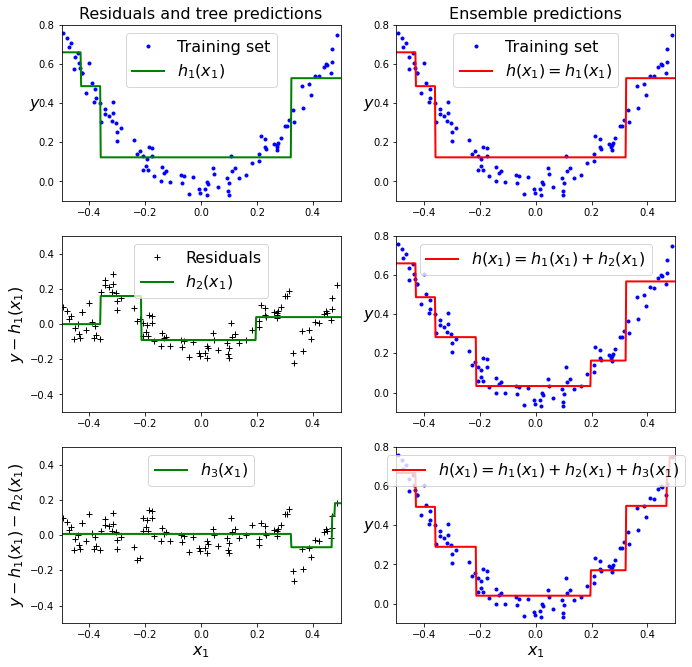

In [37]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title('Residuals and tree predictions', fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title('Ensemble predictions', fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

[GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor):GBRTの実装。
                            

In [38]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,  learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

`learning_rate`は各木の寄与を決めている。小さくすると、より多くの木が必要になるが、予測はたいてい良くなる。これはshrinkageという正則化手法。

In [39]:
gbrt_slow=GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

左はアンダーフィッティング(木が足りていない)、右はオーバーフィッティング(木が多すぎ)。

Text(0.5, 0, '$x_1$')

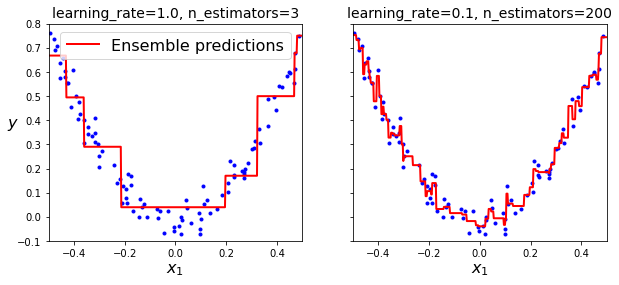

In [40]:
fix, axes =plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5,0.5,-0.1,0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5,0.5,-0.1,0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)


### Gradient Boosting with Early stopping
early stoppingで最適な木の数を見つけることができる。[staged_predict](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor.staged_predict)メソッドを用いる。ステージ(木が一つずつ増える)ごとの予測値を返すイテレータ。

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val= train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors =[mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators=np.argmin(errors)+1

gbrt_best=GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [42]:
min_error=np.min(errors)

Text(0.5, 1.0, 'Best model (56 trees)')

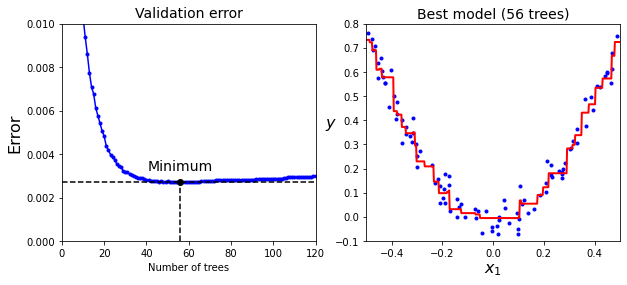

In [43]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) +1),errors, 'b.-')
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], 'k--')
plt.plot([0,120], [min_error, min_error], 'k--')
plt.plot(bst_n_estimators, min_error, 'ko')
plt.text(bst_n_estimators, min_error*1.2, 'Minimum', ha='center', fontsize=14)
plt.axis([0,120,0,0.01])
plt.xlabel('Number of trees')
plt.ylabel('Error', fontsize=16)
plt.title('Validation error', fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X,y, axes=[-0.5, 0.5, -0.1, 0.8])

plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title('Best model (%d trees)' % bst_n_estimators, fontsize=14)



`warm_start=True`とすることでもearly stoppingを実装できる。fitが呼び出されたときの現存する木を保持して数を増やしながら訓練する。以下は5連続でエラーが増えたら終了する。

In [44]:
brt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float('inf')
error_going_up =0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred=gbrt.predict(X_val)
    val_error=mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up =0
    else:
        error_going_up +=1
        if error_going_up ==5:
            break

In [45]:
print(gbrt.n_estimators)

61


In [46]:
print('Minimum validation MSE:', min_val_error)

Minimum validation MSE: 0.002712853325235463


## Using XGBoost

In [47]:
try:
    import xgboost
except ImportError as ex:
    print('Error: the xgboost library is not installed.')
    xgboost = None

C:\Users\tkuramot\anaconda3\envs\py310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [48]:
if xgboost is not None:
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred= xgb_reg.predict(X_val)
    val_error=mean_squared_error(y_val, y_pred)
    print('Validation MSE:' , val_error)

Validation MSE: 0.004000408205406276


In [49]:
if xgboost is not None:
    xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred= xgb_reg.predict(X_val)
    val_error=mean_squared_error(y_val, y_pred)
    print('Validation MSE:' , val_error)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
Validation MSE: 0.002630868681577655


In [50]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

93.5 ms ± 4.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

34 ms ± 3.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
